# 线性回归的简洁实现
[3.3节](./03.linear-networks.ipynb#线性回归的简洁实现)
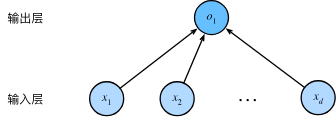
$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b = \mathbf{w}^\top \mathbf{x} + b,\ where\ \mathbf{x} \in \mathbb{R}^d, \mathbf{w} \in \mathbb{R}^d$$
$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,\ where\ \mathbf{X} \in \mathbb{R}^{n \times d}$$
$\mathbf{X}$的每一行是一个样本.
Sequential类将多个层串联在一起

In [ ]:
import torch, random
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt

# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print(features.size())
print(labels.size())
# plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

# 读取数据集
batch_size = 10
data_iter = data.DataLoader(data.TensorDataset(features, labels), batch_size=batch_size, shuffle=True)
X, y = next(iter(data_iter))
print("X =\n", X)
print("y =\n", y)

# 定义模型
net = nn.Sequential(nn.Linear(2, 1))
print(net)

# 参数初始化
"""
1. 通过`net[0]`选择网络中的第一个图层
2. 使用`weight.data`和`bias.data`方法访问参数
3. 使用替换方法`normal_`和`fill_`来重写参数值
"""
print(net[0].weight.data)
print(net[0].bias.data)
print(net[0].weight.data.normal_(0, 0.01))
print(net[0].bias.data.fill_(1))

# 验证模型和初始化参数
y_hat = torch.matmul(X, net[0].weight.data.T) + net[0].bias.data
print(torch.equal(y_hat, net(X)))

# 损失函数
loss = nn.MSELoss()

# 验证损失函数值
torch.sum((y_hat - y) ** 2)/y.numel()
loss(net(X) ,y)

# 优化算法
"""待优化的参数可通过net.parameters()获得"""
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练
num_epochs = 3
for epoch in range(num_epochs):
    if isinstance(net, torch.nn.Module):
        net.train()         # 将模型设置为训练模式
    for X, y in data_iter:
        l = loss(net(X) ,y) # 计算损失函数loss（前向传播）
        trainer.zero_grad()
        l.backward()        # 进行反向传播来计算梯度
        trainer.step()      # 用优化器来更新模型参数
    
    if isinstance(net, torch.nn.Module):
        net.eval()          # 将模型设置为评估模式
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

# softmax回归的简洁实现
[3.7节](./03.linear-networks.ipynb#softmax回归的简洁实现)  
$n$样本数量, $d$单个样本的输入维度, $q$单个样本的输出维度, 即种类总数  
单个样本的loss:
$$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &= - \sum_{j=1}^q y_j \log \hat{y}_j \ (\because \hat{y}_j = \mathrm{softmax}(o_j) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)})\\
&=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \ (\because \sum_{j=1}^q y_j = 1)\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j
\end{aligned}\end{split}$$
其导数:
$$ \frac{\partial  l(\mathbf{y}, \hat{\mathbf{y}})}{\partial {o_j}} = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(o_j) - y_j $$

$n$个样本的loss:
$$ \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)})$$

In [ ]:
import torch, torchvision, time
from torch import nn
from torchvision import transforms
from torch.utils import data
from matplotlib import pyplot as plt
from IPython import display

# 下载数据集
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../../temp", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST( root="../../temp", train=False, transform=trans, download=True)
print("训练集中的样本数量 =", len(mnist_train), ", 测试集中的样本数量", len(mnist_test))
print("size of input of first sample =", mnist_train[0][0].shape)
print("label of first sample =", mnist_train[0][1])

# 读取数据集
## 部分数据可视化
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes
batch_size = 10
data_iter = data.DataLoader(mnist_train,
                            batch_size=batch_size,
                            shuffle=True,  # 随机打乱所有样本
                            num_workers=4) # 使用4个进程来读取数据                                                              

X, y = next(iter(data_iter))
show_images(X.reshape(batch_size, 28, 28), 2, int(batch_size/2), titles=get_fashion_mnist_labels(y))

## 多进程来读取数据对比
start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256):
    continue
end = time.time()
print(end - start, "sec")

start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256, num_workers=4):
    continue
end = time.time()
print(end - start, "sec")

## 训练和测试数据
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=4)

# 定义模型
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
print(net)

# 参数初始化
for ii in range(len(net)):
    print(ii, type(net[ii]) == nn.Linear)
net[1].weight.data.normal_(0.0, 0.01) # 方法1
# nn.init.normal_(net[1].weight, mean=0.0, std=0.01) # 方法2
print(net[1].weight.data)

# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 验证
## 验证 softmax 函数
X2 = torch.normal(0, 1, (2, 5))
print("X2 =\n", X2)
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition
X_prob = softmax(X2)
print("X_prob =\n", X_prob)
### 分步验证
X_exp = torch.exp(X2)
print("X_exp =\n", X_exp)
partition = X_exp.sum(1, keepdim=True)
print("partition =\n", partition)
X_prob = X_exp / partition
print("X_prob =\n", X_prob)
print("sum of X_prob = ", X_prob.sum(1))

## 验证模型和初始参数
X, y = next(iter(data_iter))
Output = torch.matmul(X.reshape((-1, net[1].weight.data.T.shape[0])), net[1].weight.data.T) + net[1].bias.data
print(torch.equal(Output, net(X)))

## 验证loss
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
y_hat = softmax(Output)
print("y =", y)
print(cross_entropy(y_hat, y))
print(loss(net(X) ,y))

# 优化算法
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# 训练
## 准备(累加器和动画)
class Accumulator: # 累加器
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 定义分类正确函数
"""分类概率->分类结果"""
def accuracy(y_hat, y):
    """计算分类正确次数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
### 分步验证
if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
print("y_hat =", y_hat) 
print("y =    ", y) # y_hat & y defined in 验证loss
cmp = y_hat.type(y.dtype) == y # 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致
print("cmp =  ", cmp)
print("分类正确的次数 =", float(cmp.type(y.dtype).sum()))

## 使用训练集，训练模型
def train(net, train_iter, loss, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()                    # 将模型设置为训练模式
    metric = Accumulator(3)            # 累加器
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)             # 计算损失函数loss（前向传播）
        optimizer.zero_grad()
        l.mean().backward()            # 进行反向传播来计算梯度
        optimizer.step()               # 用优化器来更新模型参数

        metric.add(float(l.sum()),     # 训练损失总和
                   accuracy(y_hat, y), # 训练准确度总和
                   y.size(0))          # 样本数
    return metric[0] / metric[2], metric[1] / metric[2] # 返回训练集的平均损失和分类准确率

## 使用测试集，评估模型
def evaluate(net, test_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()                          # 将模型设置为评估模式
    metric = Accumulator(2)                 # 累加器
    with torch.no_grad():
        for X, y in test_iter:
            metric.add(accuracy(net(X), y), # 当前分类正确次数
                       y.size(0))           # 当前样本数量

    return metric[0] / metric[1]           # 返回测试集的分类准确率

## 运行多个迭代周期。 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估
num_epochs = 10
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=["train loss", "train acc", "test acc"])

for epoch in range(num_epochs):
    train_metrics = train(net, train_iter, loss, optimizer) # 训练模型
    test_acc = evaluate(net, test_iter)                     # 评估模型
    print(epoch + 1, "train loss =", train_metrics[0], ", train acc =", train_metrics[1], ", test acc =", test_acc)
    animator.add(epoch + 1, train_metrics + (test_acc,))

train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc

# 预测
num_samples = 8
X, y = next(iter(data.DataLoader(mnist_test, num_samples, shuffle=True)))
labels = get_fashion_mnist_labels(y)
outputs = get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(labels, outputs)]
show_images(torch.squeeze(X), 1, num_samples, titles=titles)

# 带参数注意力汇聚
[10.2.4节](./10.attention-mechanisms.ipynb#带参数注意力汇聚)

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# ---------------------- x_train, keys, values ----------------------

n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本
def f(x):
    return 2 * torch.sin(x) + x**0.8
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出

# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))

# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

# ---------------------- training ----------------------

class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = torch.reshape(x_train.repeat_interleave(keys.shape[1]), (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

# ---------------------- verification ----------------------

def plot_kernel_reg(y_hat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_truth, label='Truth')
    ax.plot(x_test, y_hat, label='Pred', linestyle='--')
    ax.plot(x_train, y_train, 'o', alpha=0.5);
    ax.legend(loc='upper right')
    ax.set_xlim([0, 5])
    ax.set_ylim([-1, 5])
    ax.grid(True)
    
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

# ---------------------- attention weights ----------------------

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(16, 9),
                  cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

# Bahdanau 注意力
[10.4节](./10.attention-mechanisms.ipynb#Bahdanau-注意力)

In [ ]:

import torch, os, zipfile, tarfile, hashlib, requests, collections, math
from torch import nn
from torch.utils import data

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()

# ----------------------------------------------------------------------------

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename.

    Defined in :numref:`sec_kaggle_house`"""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file.

    Defined in :numref:`sec_kaggle_house`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def read_data_nmt():
    """Load the English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding="UTF-8") as f:
        return f.read()

def preprocess_nmt(text):
    """Preprocess the English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset.

    Defined in :numref:`sec_machine_translation`"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

def count_corpus(tokens):
    """Count token frequencies.

    Defined in :numref:`sec_text_preprocessing`"""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches.

    Defined in :numref:`subsec_mt_data_loading`"""
    reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
    astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = reduce_sum(
        astype(array != vocab['<pad>'], torch.int32), 1)
    return array, valid_len

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset.

    Defined in :numref:`subsec_mt_data_loading`"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

# ----------------------------------------------------------------------------

class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                  dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

# ----------------------------------------------------------------------------

class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.

    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=0)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
    """Additive attention.

    Defined in :numref:`sec_attention-scoring-functions`"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

# ----------------------------------------------------------------------------

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

net = EncoderDecoder(encoder, decoder)

# ----------------------------------------------------------------------------

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks.

    Defined in :numref:`sec_seq2seq_decoder`"""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
        
import time
import numpy as np
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                                device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# ----------------------------------------------------------------------------

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence.

    Defined in :numref:`sec_seq2seq_training`"""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU.

    Defined in :numref:`sec_seq2seq_training`"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

# ----------------------------------------------------------------------------

from matplotlib import pyplot as plt
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(4, 3), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

# 加上一个包含序列结束词元
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')dd